In [8]:
import pandas as pd
import tensorflow as tf
import numpy as np
import sklearn
from sklearn import metrics
import transformers
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification
import json
import matplotlib.pyplot as plt
import random
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# SPECIFY PARAMETER

In [9]:
TRAIN_PATH = '../input/nlp-benchmark-intent/nlp_benchmark_intent_train.csv'
TEST_PATH = '../input/nlp-benchmark-intent/nlp_benchmark_intent_validation.csv'
BATCH_SIZE=32
TRAIN_SPLIT = 0.8
VAL_SPLIT = 0.2
EPOCHS=2
INTENT_VAR = 'category'
TEXT_VAR = 'query'
CATS =['BookRestaurant', 'SearchScreeningEvent','RateBook','GetWeather','AddToPlaylist', 'PlayMusic','SearchCreativeWork']

# READ IN DATA

In [10]:
#Load data
train_df = pd.read_csv(TRAIN_PATH)
test_df = pd.read_csv(TEST_PATH)


# FINE-TUNING ROBERTA MODEL

In [11]:

class Model_Finetuning(): 

    def get_dataset_partitions_tf(self,ds, ds_size, train_split, val_split, batch_size, shuffle=True, shuffle_size=10000):
        assert (train_split + val_split) == 1
    
        if shuffle:
            # Specify seed to always have the same split distribution between runs
            ds = ds.shuffle(shuffle_size, seed=12)
    
            train_size = int(train_split * ds_size)
            val_size = int(val_split * ds_size)
    
            train_ds = ds.take(train_size).batch(batch_size, drop_remainder=True)     
            val_ds = ds.skip(train_size).take(val_size).batch(batch_size, drop_remainder=True) 
    
            return train_ds, val_ds
    
    def classification_roberta(self,train_data, test_data, intent_var, text_var):
        n_categories=train_data[intent_var].nunique()
        #print(n_categories)
    
        train_labels = list(train_data[intent_var])
        train_texts = list(train_data[text_var])

        n_categories=train_data[intent_var].nunique()
        ds_size = len(train_data)
        ###train
        tokenizer = AutoTokenizer.from_pretrained("roberta-base") #Tokenizer
        train_inputs = tokenizer(train_texts, padding=True, truncation=True, return_tensors='tf') #Tokenized text
    
        train_dataset=tf.data.Dataset.from_tensor_slices((dict(train_inputs), train_labels)) #Create a tensorflow dataset
        ###test
        test_texts = list(test_data[text_var])
        test_inputs =  tokenizer(test_texts, padding=True, truncation=True, return_tensors='tf') #Tokenized text
    
        train_ds, val_ds = self.get_dataset_partitions_tf(train_dataset, ds_size,train_split=TRAIN_SPLIT, val_split=VAL_SPLIT, batch_size= BATCH_SIZE, shuffle=True, shuffle_size=10000 )
    
        model = TFAutoModelForSequenceClassification.from_pretrained("roberta-base", num_labels=n_categories)
        model.compile(
               optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5, clipnorm=1.),
               loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
               metrics=[tf.metrics.SparseCategoricalAccuracy(),tf.keras.metrics.SparseTopKCategoricalAccuracy(k=3, name='Sparse_Top_3_Categorical_Accuracy')],
                )
 
        history=model.fit(train_ds, validation_data=val_ds, epochs=EPOCHS, verbose=1)

        model.save_weights('./saved_weights.h5')

        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.ylabel('model loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='best')
        plt.savefig('train_history.png')
        plt.show()
    
        loaded_model =  TFAutoModelForSequenceClassification.from_pretrained("roberta-base", num_labels=n_categories)
        loaded_model.load_weights('./saved_weights.h5')
        test_prediction = loaded_model(test_inputs)
        test_prediction_probs = tf.nn.softmax(test_prediction[0],axis=1).numpy()
        ypred = np.argmax(test_prediction_probs, axis=1)
        ytest= test_df[intent_var].values
 
        conf_matrix = confusion_matrix(ytest,ypred)
        fig,ax = plt.subplots(figsize=(8,6))
        sns.heatmap(pd.DataFrame(conf_matrix), annot = True, cmap = 'YlGnBu',fmt = 'g')
        ax.xaxis.set_label_position('top')
        plt.tight_layout()
        plt.title('Confusion Matrix', fontsize=20, y=1.1)
        plt.ylabel('Actual label', fontsize=15)
        plt.xlabel('Predicted label', fontsize=15)
        plt.show()
        print(classification_report(ytest,ypred ))
        return ytest, ypred

All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

Some layers of TFRobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/2
344/344 [==============================] - 82s 198ms/step - loss: 0.3544 - sparse_categorical_accuracy: 0.9156 - Sparse_Top_3_Categorical_Accuracy: 0.9651 - val_loss: 0.0569 - val_sparse_categorical_accuracy: 0.9884 - val_Sparse_Top_3_Categorical_Accuracy: 0.9996
Epoch 2/2
344/344 [==============================] - 66s 192ms/step - loss: 0.0514 - sparse_categorical_accuracy: 0.9884 - Sparse_Top_3_Categorical_Accuracy: 1.0000 - val_loss: 0.0333 - val_sparse_categorical_accuracy: 0.9913 - val_Sparse_Top_3_Categorical_Accuracy: 1.0000


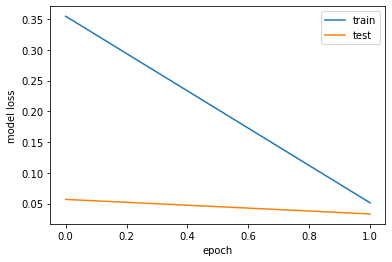

All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

Some layers of TFRobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


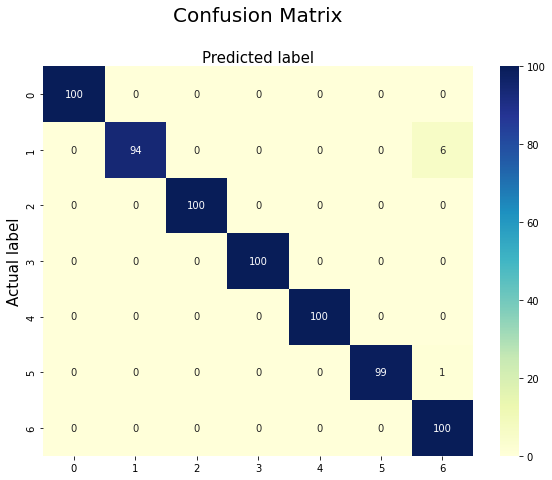

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       100
           1       1.00      0.94      0.97       100
           2       1.00      1.00      1.00       100
           3       1.00      1.00      1.00       100
           4       1.00      1.00      1.00       100
           5       1.00      0.99      0.99       100
           6       0.93      1.00      0.97       100

    accuracy                           0.99       700
   macro avg       0.99      0.99      0.99       700
weighted avg       0.99      0.99      0.99       700



In [12]:
model_obj = Model_Finetuning()
ytest, ypred=model_obj.classification_roberta(train_df, test_df,  INTENT_VAR, TEXT_VAR)